Contenido bajo licencia Creative Commons BY 4.0 y código bajo licencia MIT. © Juan Gómez y Nicolás Guarín-Zapata 2020. Este material es parte del curso Modelación Computacional en el programa de Ingeniería Civil de la Universidad EAFIT.

# Determinación de raíces

## Introducción

El problema de determinar las raíces o ceros de una función aparece de manera frecuente en múltiples problemas de ingeniería. En este notebook discutiremos 2 de los métodos mas usados para su solución tales como el método de Bisección y el método de Newton-Raphson. El primero es interesante debido a su caracter intuitivo, mientras que el segundo, además de su mejor desempeño, es la base para la solución de problemas no-líneales de mayor complejidad como los que aparecen en métodos de elementos finitos. Para presentar los métodos utilizaremos un ejemplo tomado de un problema de la mecánica de los medios continuos.

**Al completar este notebook usted debería estar en la capacidad de:**

* Reconocer en detalle los aspectos algorítmicos de los métodos de búsqueda de raíces de Bisección y Newton-Raphson.

* Formular apropiadamemte un problema como uno de búsqueda de raíces.

* Reconocer la diferencia entre convergencia y divergencia de un proceso iterativo.

* Resolver manualmente y con la ayuda del computador problemas de búsqueda de raíces.

## Ejemplo: Determinación de tensiones extremas en un sólido elástico

En un problema de análisis de tensiones para un sólido elástico se encuentra que los máximos esfuerzos $\sigma$ son las raíces del polinomio caracteristico correspondiente a la siguiente función:

\begin{equation}
f(\sigma)=\sigma ^3 -200 \sigma ^2 -100000 \sigma
\end{equation}

y en donde $\sigma \in [-500 , 500].$ Para efectos de verificar si una condición de diseño del sólido es apropiada se requiere determinar los valores extremos.<sup>[Ref 1](#Referencias)</sup>


In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

### Paso 1: localización inicial de las raíces


Inicialmente haremos una búsqueda o localización inicial, de baja precisión, de las raíces para posteriormente afinar los valores usando métodos mas formales. Como estrategia inicial para localizar las raíces es conveniente graficar la función. En el siguiente bloque de código usaremos la función **lambda** de Python para definir la función.

<IPython.core.display.Javascript object>


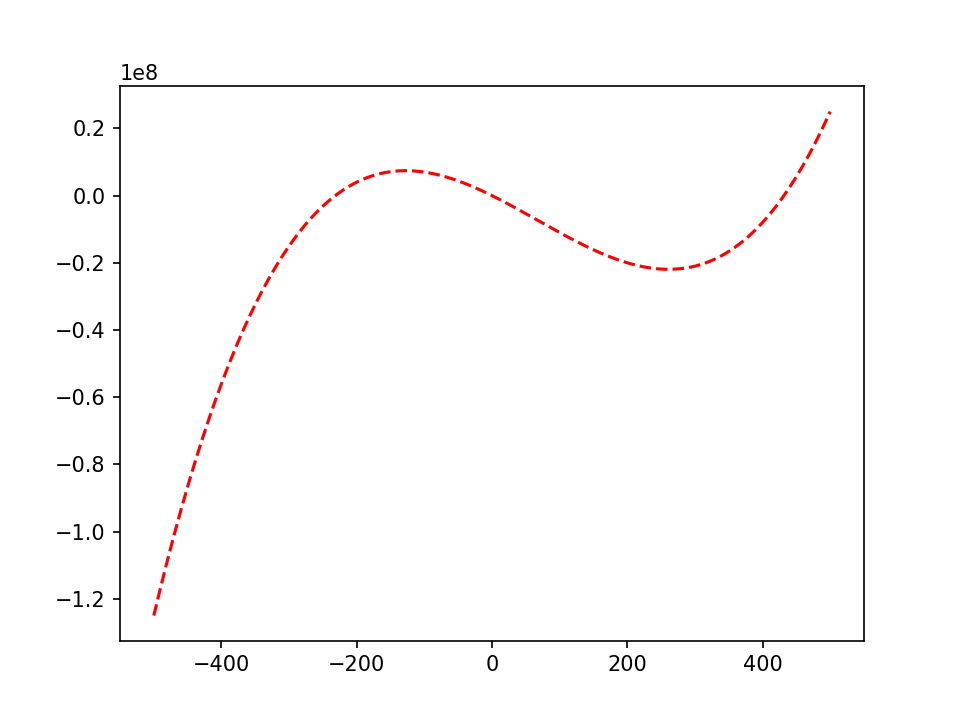

In [2]:
fx  = lambda x: x**3 - 200.0*x**2 - 100000.0*x
fxd = lambda x: 3.0*x**2 - 400.0*x - 100000.0
npts = 200                     
x = np.linspace(-500, 500, npts)
y = fx(x)
plt.figure(0)                    
plt.plot(x , y ,'r--')         

<div class="alert alert-warning">

**Preguntas**
    
- Modificar los ejes de la grafica y adicionar una cuadricula para facilitar la  identificaciòn aproximada de las raíces.

- ¿Cuales son los valores aproximados de las raìces que se obtienen de la grafica?
</div>

Para hacer la búsqueda inicial usaremos el algoritmo de bracketing el cual recibe como parámetros de entrada a la función, los extremos del intervalo de búsqueda y el numéro de intervalos a considerar. En el siguiente bloque de código definimos la rutina **bracketing** de manera que esta pueda ser utilizada de forma general.

In [3]:
# Comentar apropiadamente el siguiente código

def bracketing(fun, a, b, N):
    """Estimate the root of a real function using bracketing
    Parameters
    ----------
    fun : function
        Function.
    a : float
        Initial point of the interval.
    b : float
        Final point of the interval.
    N : int
        NUmber of subdivisions for the interval
    Returns
    -------
    xR : array
        Array with initial estimates for roots.
    msg : string
        Message regarding the success of the method.
    """
    msg = "Maximum number of iterations reached."
    dx = (b - a)/(N - 1)
    iroot = 0
    x2 = a
    xR = np.zeros(N, float)
    for i in range(0, N):
        x1 = x2
        x2 = x1 + dx
        if (fun(x1) * fun(x2)) < 0:
            msg = "A change of sign was found."
            iroot = iroot + 1
            xR[i] = x1
    return xR, msg

En el uso de la rutina de búsqueda partiremos el dominio del problema en $N = 100$ sub-intervalos de manera que tendremos:

$$\triangle\sigma=\frac{b-a}{100}\equiv\frac{1000}{100}$$

<div class="alert alert-warning">

**Preguntas**
    
- ¿Qué tan cercanas son las raíces encontradas por la rutina con las identificadas en la grafica?

- ¿Qué pasa si se cambia el valor del numero de sub-intervalos en la operación de bracketing?
</div>

In [4]:
xR, msg = bracketing(fx , -500 , 500 , 10)
print(xR)

[   0.            0.         -277.77777778    0.          -55.55555556
    0.            0.            0.          388.88888889    0.        ]


### Paso 2a: Afinación de la raíz por el método de bisección

El método de bisección consiste en la partición por mitades e identificación de la mitad en la que se presenta el cambio de signo, como se muestra en la figura. El método cada vez toma un sub-intervalo de menor tamaño variando la posición del punto $x_3$.


<center><img src="images/biseccion.svg" alt="files" style="width:500px"></center>

La siguiente rutina toma como parámetros de entrada la función; los valores extremos del intervalo de búsqueda $a$ y $b$; y 2 valores de tolerancia usados para detectar la presencia de una raíz ya sea por el tamaño del intervalo de búsqueda por la cercanía con cero del valor de la función.

In [5]:
# Comentar apropiadamente el siguiente código

def bisection(fun, a, b, xtol=1e-6, ftol=1e-12, verbose=False):
    """Use bisection method to estimate the root of a real function
    Parameters
    ----------
    fun : function
        Function.
    grad : function
        Derivative of the function.
    a : float
        Initial point of the interval.
    b : float
        Final point of the interval.
    xtol : float, optional
        Tolerance for the interval.
    ftol : float, optional
        Tolerance for the root.
    verbose : bool, optional
        If True, prints each iteration.
    Returns
    -------
    x : array
        Approximated root.
    msg : string
        Message regarding the success of the method.
    """
    if fun(a) * fun(b) > 0:
        c = None
        msg = "The function should have a sign change in the interval."
    else:
        nmax = int(np.ceil(np.log2((b - a)/xtol)))
        for cont in range(nmax):
            c = 0.5*(a + b)
            if verbose:
                print("n: {}, x: {}".format(cont, c))
            if abs(fun(c)) < ftol:
                msg = "Root found with desired accuracy."
                break
            elif fun(a) * fun(c) < 0:
                b = c
            elif fun(b) * fun(c) < 0:
                a = c
            msg = "Maximum number of iterations reached."
    return c, msg

In [6]:
c , msg = bisection(fx, -300.0, -200.0, xtol=1e-6, ftol=1e-12, verbose=False)
print(c)
c , msg = bisection(fx, -100.0, 0.100, xtol=1e-6, ftol=1e-12, verbose=False)
print(c)
c , msg = bisection(fx,  300.0, 500.0, xtol=1e-6, ftol=1e-12, verbose=False)
print(c)

-231.66247829794884
4.80562448505559e-07
431.66247829794884


<div class="alert alert-warning">

**Pregunta**
    
Para al menos una de las raíces pruebe con diferentes rangos de localización de la raíz e indique el desempeño del algoritmo en términos del número de iteraciones.
</div>


### Paso 2b: Afinación de la raíz por el método de Newton-Raphson

Recordemos el método de Newton-Raphson el cual consiste en extender la recta tangente en el punto actual $x_i$ hasta que cruce el cero para luego hacer la aproximación en la abscisa de dicho punto de cruce (ver figura). Considerando la pendiente en $x_i$ se tiene que:

$$
f'(x_i)\equiv m=\frac{0-f(x_i)}{x_{i+1}-x_i}
$$

resultando en la iteración de Newton-Raphson:

$$
x_{i+1}=x_i-\frac{f(x_i)}{f'(x_i)}
$$


<center>
    <img src="img/newton_iter.svg"
         alt="Esquema del método de Newton."
         style="width:500px">
</center>

En el siguiente bloque de código se implementa la iteración de Newton-Raphson. Note que además de la función el algoritmo requiere como parámetros de entrada la primera derivada y un valor inicial de la raíz. El algoritmo llega a una condición de divergencia ya sea por que excede el máximo número de iteraciones o por llegar a derivadas cercanas al cero.

In [7]:
# Comentar apropiadamente el siguiente código

def newton(fun, grad, x, niter=50, ftol=1e-8, verbose=False):
    """Use Newton method to estimate the root of a real function
    Parameters
    ----------
    fun : function
        Function.
    grad : function
        Derivative of the function.
    x : float
        Initial estimate.
    niter : int, optional
        Maximum number of iterations.
    ftol : float, optional
        Tolerance for the root.
    verbose : bool, optional
        If True, prints each iteration.
    Returns
    -------
    x : array
        Approximated root.
    msg : string
        Message regarding the success of the method.
    """
    msg = "Maximum number of iterations reached."
    for cont in range(niter):
        if abs(grad(x)) < ftol:
            x = None
            msg = "Derivative near to zero."
            break
        if verbose:
            print("n: {}, x: {}".format(cont, x))
        x = x - fun(x)/grad(x)
        if abs(fun(x)) < ftol:
            msg = "Root found with desired accuracy."
            break
    return x, msg

In [8]:
c , msg = newton(fx, fxd, -230.0, niter=50, ftol=1e-8, verbose=True)
print(c, "\n")
c , msg = newton(fx, fxd, -51.0, niter=50, ftol=1e-8, verbose=True)
print(c, "\n")
c , msg = newton(fx, fxd, 430.0, niter=50, ftol=1e-8, verbose=False)
print(c, "\n")

n: 0, x: -230.0
n: 1, x: -231.67883211678833
n: 2, x: -231.6624805928219
-231.66247903554 

n: 0, x: -51.0
n: 1, x: 10.94059640374946
n: 2, x: 0.20496836097227877
n: 3, x: 8.378324920088609e-05
n: 4, x: 1.4039249228220071e-11
3.9420326066980225e-25 

431.66247903554 



## Glosario de términos


**Raíz de una función $f(x)$:** Valor (o valores) de $x$ para los cuales se da la condición $f(x)=0$

**Convergencia:** Aproximaciones sucesivas a un valor buscado a través de un proceso iterativo.

**Tolerancia:** Número real para definir el cero computacional en un algoritmo.

**Método de bisección:** Algoritmo que localiza la raiz de una función $f(x)$ a través de particiones sucesivas del intervalo de búsqueda.

**Método de Newton-Raphson:** Algoritmo que localiza la raíz de una función $f(x)$ a partir de la ecuación de la tangente en una aproximación inicial de la raíz.

Los métodos de Bisección y de Newton-Raphson se encuentran detallados en Press et al (1996). En esta última referencia es de interés el problema de la generalización del método de Newton-Raphson a la determinación de la raíz $\overrightarrow x$ donde $\overrightarrow x$ es ahora un vector.

## Actividad para la clase

El método de Newton-Raphson resulta de la ecuación de la tangente en un punto $x_i  $asumido como raíz de la función. Este método tiene como desventaja la necesidad de requerir la primera derivada de la función $f'(x)$, la cual no siempre esta disponible. Se puede formular también una iteración alternativa que evite el uso de $f'(x)$ si se hace uso de la recta secante entre 2 puntos $x_i$ y $x_{i+1}$ como se ilustra en la figura.


<center>
    <img src="img/secante_iter.svg"
         alt="Esquema del método de la secante."
         style="width:500px">
</center>

Para derivar el método partimos de dos puntos $x_i$ y $x_{i-1}$, y encontramos la recta
secante que pasa por estos. Extendiendo la misma hasta su cruce con cero resulta en:

$$m = \frac{0 - f(x_i)}{x_{i + 1} - x_{i}}\, ,$$

y sabiendo que $m = (f(x_i) - f(x_{i - 1}))/(x_{i} - x_{i - 1})$, se tiene la siguiente iteración:

$$x_{i + 1} = x_i - f(x_i) \frac{x_{i} - x_{i - 1}}{f(x_i) - f(x_{i - 1})}\, .$$



<div class="alert alert-warning">

1. Modificar la rutina de Newton-Raphson de manera que determine la raíz de $f(x)$ usando el método de la secante.

2. Para la función del ejemplo determinar sus raíces usando los métodos de Newton-Raphson y de la secante y compare su desempeño en términos de precisión y número de iteraciones.

</div>


## Referencias

1. Gómez, Juan., Sierra, César., Vergara, Juan., Sáenz, Mario., and Guarín-Zapata, Nicolás. (2018) [Notas de clase: Mecánica del medio continuo](https://github.com/AppliedMechanics-EAFIT/Notas-MMC/raw/master/notas_de_clase/notas_medios.pdf). Universidad EAFIT.

2. Press, W. H., Teukolsky, S. A., Vetterling, W. T., & Flannery, B. P. (1996). Numerical recipes in Fortran 90. Cambridge: Cambridge university press.

## Formato del notebook

La siguiente celda cambia el formato del Notebook.

In [9]:
from IPython.core.display import HTML
def css_styling():
    styles = open('./nb_style.css', 'r').read()
    return HTML(styles)
css_styling()